# 实战！构建基于客户细分的 K-Means 聚类算法！


代码zu
>博客地址 https://hidadeng.github.io
>
>公众号: 大邓和他的Python

客群细分对于企业了解目标受众非常重要。根据受众群体的不同，我们可以给采取不同的营销策略。目前有许多无监督的机器学习算法可以帮助公司识别他们的用户群并创建消费群体。

在本文中，我将分享一种目前比较流行的 K-Means 聚类的无监督学习技术。K-Means的目标是将所有可用的数据分组为彼此不同的不重叠的子组。K-Means聚类是数据科学家用来帮助公司进行客户细分的常用技术。

在本文中，你将了解以下内容：

K-Means聚类的数据预处理
从头构建K-Means聚类算法
用于评估聚类模型性能的指标
可视化构建簇类
簇类构建的解读与分析


<br>

## 预备知识
在开始之前安装以下库：pandas、numpy、matplotlib、seaborn、sciket learn、kneed。完成后，我们就可以开始制作模型了！

本文中要的数据集可以文末下载，运行以下代码行以导入必要的库并读取数据集：

In [1]:
import pandas as pd

df = pd.read_csv('Mall_Customers.csv')
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

数据集中有五个变量。CustomerID是数据集中每个客户的唯一标识符，我们可以删除这个变量。它没有为我们提供任何有用的集群信息。由于 gender 是一个分类变量，它需要编码并转换成数字。

在输入模型之前，其他所有变量都将按正态分布进行缩放。我们将标准化这些变量，平均值为0，标准偏差为1。

<br>

## 标准化变量
首先，让我们标准化数据集中的所有变量，使它们在相同的范围内。

In [2]:
from sklearn.preprocessing import StandardScaler

col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

Annual Income (k$)       Age  Spending Score (1-100)
0           -1.738999 -1.424569               -0.434801
1           -1.738999 -1.281035                1.195704
2           -1.700830 -1.352802               -1.715913
3           -1.700830 -1.137502                1.040418
4           -1.662660 -0.563369               -0.395980

我们可以看到所有的变量都被转换了，现在都以零为中心。

<br>

## 热编码
变量"gender"是分类变量，我们需要把它转换成一个数值变量，可以用pd.get_dummies()来处理。

In [24]:
gender = df['Gender']
newdf = scaled_features.join(gender)

newdf = pd.get_dummies(newdf, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

newdf = newdf.drop(['Gender_Male'], axis=1)

newdf.head()

Annual Income (k$)       Age  Spending Score (1-100)  Gender_Female
0           -1.738999 -1.424569               -0.434801              0
1           -1.738999 -1.281035                1.195704              0
2           -1.700830 -1.352802               -1.715913              1
3           -1.700830 -1.137502                1.040418              1
4           -1.662660 -0.563369               -0.395980              1

可以看到，性别变量已经发生了变化，从数据框中删除了“Gender_Male”。这是因为不需要再保留变量了。


<br>

## 建立聚类模型
让我们构建一个 K-means 聚类模型，并将其拟合到数据集中的所有变量上，我们用肘部图可视化聚类模型的性能，它会告诉我们在构建模型时使用的「最佳聚类数」。

Text(0, 0.5, 'Inertia')

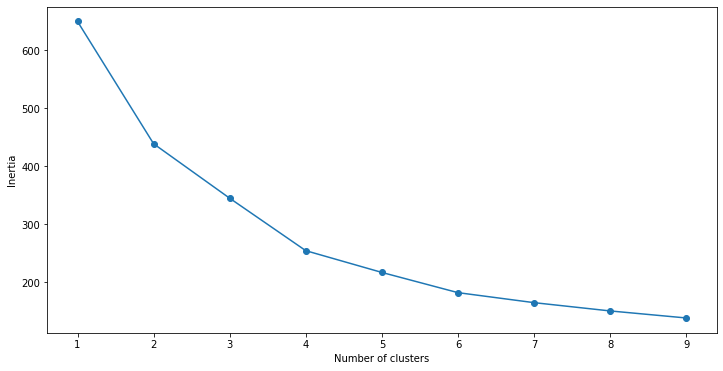

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

根据上面的「肘部图」，我们可以看到最佳聚类数为「4」

<br>


## 轮廓系数
轮廓系数或轮廓分数是用于评估该算法创建的簇的质量的方法。轮廓分数在-1到+1之间。轮廓分数越高，模型越好。轮廓分数度量同一簇中所有数据点之间的距离。这个距离越小，轮廓分数就越好。

让我们计算一下我们刚刚建立的模型的轮廓分数：

In [12]:
from sklearn.metrics import silhouette_score
# First, build a model with 4 clusters

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(newdf)

# Now, print the silhouette score of this model

print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.35027020434653977


轮廓线得分约为「0.35」。这是一个不错的模型，但我们可以做得更好，并尝试获得更高的簇群分离。

在我们尝试这样做之前，让我们将刚刚构建的聚类可视化，以了解模型的运行情况：

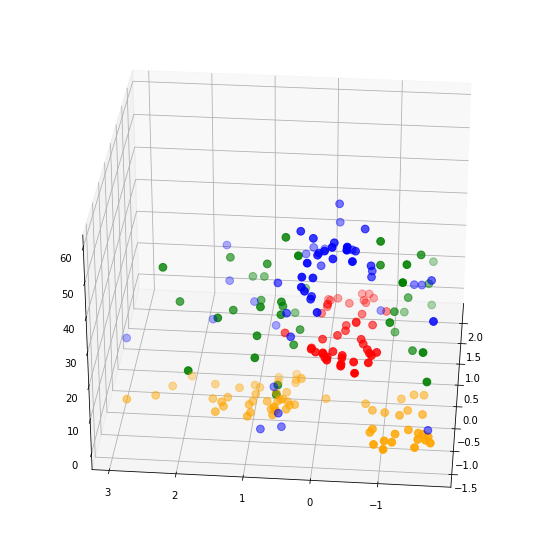

In [34]:
clusters = kmeans.fit_predict(newdf.iloc[:,1:])

newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf['Age'][newdf.label == 0], 
           newdf["Annual Income (k$)"][newdf.label == 0], 
           df["Spending Score (1-100)"][newdf.label == 0], 
           c='blue', s=60)

ax.scatter(newdf['Age'][newdf.label == 1], 
           newdf["Annual Income (k$)"][newdf.label == 1], 
           newdf["Spending Score (1-100)"][newdf.label == 1], 
           c='red', s=60)

ax.scatter(newdf['Age'][newdf.label == 2], 
           newdf["Annual Income (k$)"][newdf.label == 2], 
           df["Spending Score (1-100)"][newdf.label == 2], 
           c='green', s=60)

ax.scatter(newdf['Age'][newdf.label == 3], 
           newdf["Annual Income (k$)"][newdf.label == 3], 
           newdf["Spending Score (1-100)"][newdf.label == 3], 
           c='orange', s=60)

ax.view_init(30, 185)
plt.show()

从上图可以看出，簇类分离度不是很大。红点与蓝色混合，绿色与黄色重叠，这与轮廓分数一起向我们表明该模型表现不佳。现在，让我们创建一个比这个模型具有更好集群可分离性的新模型。

<br>

## 建立聚类模型2
对于这个模型，让我们做一些特征选择。我们可以使用一种叫做主成分分析（PCA）的技术。

PCA 是一种帮助我们降低数据集维数的技术。现在，让我们在数据集上运行PCA：

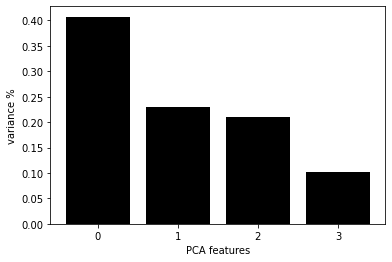

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

这张图表显示了每个主成分分析的组成，以及它的方差。我们可以看到前两个主成分解释了大约70%的数据集方差。我们可以将这两个组件输入到模型中再次构建模型，并选择要使用的簇的数量

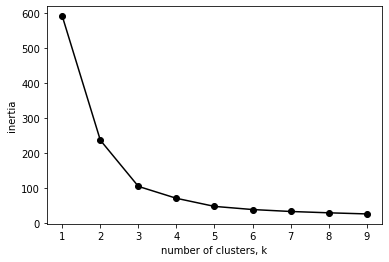

In [36]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

同样，看起来「最佳簇数是4」。我们可以用4个簇来计算此模型的轮廓分数：

In [37]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

0.6025604455573874


这个模型的轮廓分数是「0.42」，这比我们之前创建的模型要好。我们可以像前面一样可视化此模型：

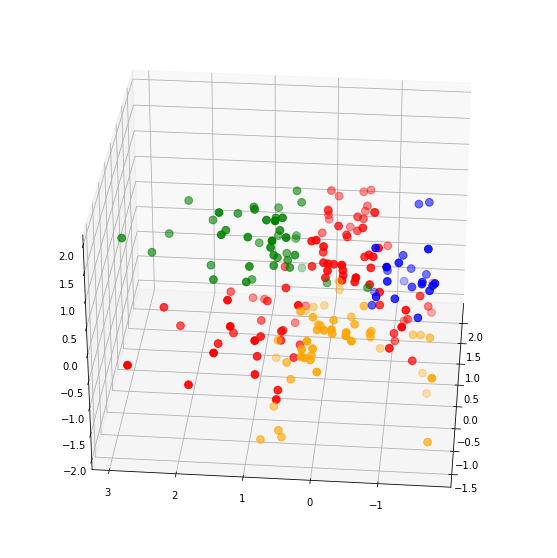

In [38]:
model = KMeans(n_clusters=4)

clusters = model.fit_predict(PCA_components.iloc[:,:2])
newdf["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newdf.Age[newdf.label == 0], newdf["Annual Income (k$)"][newdf.label == 0], newdf["Spending Score (1-100)"][newdf.label == 0], c='blue', s=60)
ax.scatter(newdf.Age[newdf.label == 1], newdf["Annual Income (k$)"][newdf.label == 1], newdf["Spending Score (1-100)"][newdf.label == 1], c='red', s=60)
ax.scatter(newdf.Age[newdf.label == 2], newdf["Annual Income (k$)"][newdf.label == 2], newdf["Spending Score (1-100)"][newdf.label == 2], c='green', s=60)

ax.scatter(newdf.Age[newdf.label == 3], newdf["Annual Income (k$)"][newdf.label == 3], newdf["Spending Score (1-100)"][newdf.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

<br> 

## 模型1与模型2

让我们比较一下这个模型和第一个模型的聚类可分性：

第二个模型中的簇比第一个模型中的簇分离得好得多。此外，第二个模型的轮廓分数要高得多。基于这些原因，我们可以选择第二个模型进行分析。


<br>

## 聚类分析
首先，让我们将簇类映射回数据集，并查看数据帧。

In [39]:
df = pd.read_csv('Mall_Customers.csv')
df = df.drop(['CustomerID'],axis=1)

# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)  cluster
0    Male   19                  15                      39        3
1    Male   21                  15                      81        0
2  Female   20                  16                       6        3
3  Female   23                  16                      77        0
4  Female   31                  17                      40        3

数据帧中的每一行现在都分配给一个集群。要比较不同群集的属性，请查找每个群集上所有变量的平均值：

In [41]:
avg_df = df.groupby(['cluster'], as_index=False).mean()

avg_df

cluster        Age  Annual Income (k$)  Spending Score (1-100)
0        0  25.521739           26.304348               78.565217
1        1  51.681818           62.125000               33.750000
2        2  32.904762           84.380952               80.500000
3        3  26.659574           53.106383               40.042553

如果我们将这些簇可视化，我们可以更容易地解释它们。运行以下代码以获得每个变量的不同可视化效果：

<AxesSubplot:xlabel='cluster', ylabel='Age'>

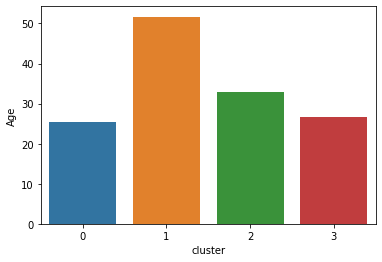

In [44]:
import seaborn as sns

sns.barplot(x='cluster',y='Age',data=avg_df)

<AxesSubplot:xlabel='cluster', ylabel='Spending Score (1-100)'>

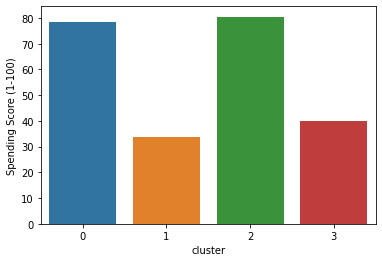

In [45]:
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df)

<AxesSubplot:xlabel='cluster', ylabel='Annual Income (k$)'>

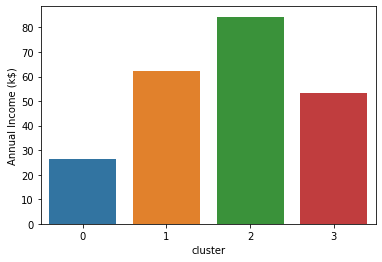

In [46]:
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df)

In [47]:
df2 = pd.DataFrame(df.groupby(['cluster','Gender'])['Gender'].count())
df2.head()

Gender
cluster Gender        
0       Female      14
        Male         9
1       Female      47
        Male        41
2       Female      23

各细分市场的主要特点

**簇类0**:
- 年平均收入高，支出低。
- 平均年龄在40岁左右，性别以男性为主。


**簇类1**：
- 中低收入，平均消费能力。
- 平均年龄在50岁左右，性别以女性为主。


**簇类2**：
- 平均收入低，消费分数高。
- 平均年龄在25岁左右，性别以女性为主。


**簇类3**：
- 平均收入高，消费分数高。
- 平均年龄在30岁左右，性别以女性为主。


值得注意的是，计算年龄中位数将有助于更好地了解每个集群内的年龄分布。

而且，女性在整个数据集中的代表性更高，这就是为什么大多数集群中女性的数量比男性多。我们可以找到每个性别相对于整个数据集中的数字的百分比，以便更好地了解性别分布。

<br>

## 为每个簇类构建角色
作为一名数据科学家，能够用你的分析讲述一个故事是一项重要的技能，这将帮助你的客户或利益相关者更容易理解你的发现。下面是一个基于创建的簇类构建消费者角色的示例：

### 簇类0
这个角色由对金钱非常谨慎的中年人组成。尽管与所有其他群体中的个人相比，他们的平均收入最高，但花费最少。这可能是因为他们有经济责任——比如为孩子的高等教育存钱。

建议：促销、优惠券和折扣代码将吸引这一领域的个人，因为他们倾向于少花钱。

### 簇类1
这部分人包括一个年龄较大的群体。他们挣的少，花的少，而且可能正在为退休储蓄。

建议：针对这些人的营销可以向这一领域的人推广医疗保健相关产品。

### 簇类2
这一部分由较年轻的年龄组组成。这部分人最有可能是第一批求职者。与其他人相比，他们赚的钱最少。然而，这些人都是热情的年轻人，他们喜欢过上好的生活方式，而且往往超支消费。

建议：由于这些年轻人花费很多，给他们提供旅游优惠券或酒店折扣可能是个好主意。为他们提供折扣的顶级服装和化妆品品牌也将很好地为这一部分。

### 簇类3
这部分人是由中年人组成的。这些人努力工作，积累了大量财富。他们也花大量的钱来过好的生活。

建议：由于他们的消费能力和人口结构，这些人很可能会寻找房产购买或投资。



<br>

## 结论
在本文中，我已经详细的建立了一个用于客户细分的 K-Means 聚类模型。我们还探讨了聚类分析，并分析了每个聚类中个体的行为。最后，我们看了一些可以根据集群中每个人的属性提供的业务建议。